<a href="https://colab.research.google.com/github/DmitriySechkin/ds-learning-sb/blob/main/dom_rf_task1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Выполнение домашнего задания**

[Task dmrf 1](https://colab.research.google.com/drive/1PhLZhEMKvuYru_eem5Jjxa14Zznz4ktD#scrollTo=vbgJJegHLUMa&line=1&uniqifier=1) - *извлечение данных*

[Task dmrf 2](https://colab.research.google.com/drive/1PhLZhEMKvuYru_eem5Jjxa14Zznz4ktD#scrollTo=IAkU-k9w9ezb&line=1&uniqifier=1) - *анализ выборки*

In [ ]:
import requests
from tqdm.auto import tqdm

In [ ]:
offset_ = 1 # размер шага
limit_ = 1000 # количество объектов в выдаче
all_objects_data = []
index = 0

while True:
  url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
  res = requests.get(url)
  data = res.json()
  objects_data = data.get('data').get('list')

  all_objects_data.extend(objects_data)

  print(index)

  if(len(objects_data) == 0):
    print('скачивание данных по объектам завершено')
    break


  offset_ += limit_
  index += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
скачивание данных по объектам завершено


In [ ]:
obj_ids = []

for objects_data in tqdm(all_objects_data):
   obj_id = objects_data.get('objId')
   if obj_id:
    obj_ids.append(obj_id)

  0%|          | 0/11713 [00:00<?, ?it/s]

In [ ]:
len(obj_ids) == len(all_objects_data)

True

In [ ]:
# подключение гугл-диска, на нем будем хранить базу данных, чтобы данные не терялись
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
import sqlite3

In [ ]:
error_request_obj = []

In [ ]:
# название таблицы, в которой храним первоначальный датафрейм
df_table = 'buildings'

In [ ]:
class DbRepository:

  def __init__(self, table_name):
    self._db_path = r'drive/MyDrive/buildings_db.db'
    self._table = table_name
    self._operation_type = 'append'

  def save_df(self, df):
    with sqlite3.connect(self._db_path) as con:
      df.to_sql(self._table, con, index=False, if_exists="replace")

  def get_df(self):
    query = f'select * from {self._table}'
    with sqlite3.connect(self._db_path) as con:
      return pd.read_sql(query, con)

  @property
  def db_path(self):
    return self._db_path

  @property
  def db_table(self):
    return self._table

In [ ]:
# перевод объектов в строковый формат, для сохранения в базе данных

def handle_df_for_db(df):
  problematic_columns = []
  for column in df.columns:
      if df[column].dtype not in ['int64', 'float64', 'datetime64[ns]']:
          problematic_columns.append(column)

          try:
              df[column] = df[column].astype('str')
          except:
            print(column)
  return df

In [ ]:

def fetch_data(obj_id):
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{obj_id}'
    res = requests.get(url)

    if res.status_code == 200:
        return res.json().get('data')
    else:
        error_request_obj.append(obj_id)
        print(f"Ошибка при запросе для obj_id={obj_id}. HTTP статус: {res.status_code}")
        return None

with ProcessPoolExecutor(max_workers=30) as executor:
    results = list(tqdm(executor.map(fetch_data, obj_ids), total=len(obj_ids)))



  0%|          | 0/11713 [00:00<?, ?it/s]

In [ ]:
# если получены не все объекты
if len(error_request_obj) != 0:
    for obj in error_request_obj:
      json = fetch_data(obj)

In [ ]:
results[0]

In [ ]:
df = pd.json_normalize(results)

In [ ]:
df.shape

(11713, 110)

In [ ]:
# проверяем, что получены данные по всем объектам
df.shape[0] == len(obj_ids)

True

In [ ]:
name_file = 'building_objects'
df.to_csv(f'drive/MyDrive/{name_file}.csv', index=False)
df.to_excel(f'{name_file}.xlsx', index=False)
df.to_pickle(f'{name_file}.pkl')

In [ ]:
df1 = handle_df_for_db(df)

In [ ]:
# сохраняем данные в БД
db_repository = DbRepository('buildings')
db_repository.save_df(df1)

In [ ]:
df2 = pd.read_csv('drive/MyDrive/building_objects.csv')

In [ ]:
df2['photoRenderDTO'].values.tolist()[0]

"[{'objId': 13383, 'pdId': 28105, 'rpdId': 804699, 'devId': 306, 'ordNum': 1, 'objRenderPhotoSize': 1433738, 'objRenderPhotoUrl': 'https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/file/6C6B7A3A7DA9AAFAA1F245B09666D97D31445BA1', 'objRenderPhotoDttm': '12-05-2021 16:56', 'objRenderPhotoHiddenFlg': 0, 'objRenderPhotoNm': 'IMG_20210512_093657.jpg', 'objReadyDesc': 'Строится', 'objBuildTypeShortDesc': 'Жилое', 'knFlg': 1, 'loadDttm': '16-12-2023 01:18'}, {'objId': 13383, 'pdId': 28105, 'rpdId': 804699, 'devId': 306, 'ordNum': 2, 'objRenderPhotoSize': 1304772, 'objRenderPhotoUrl': 'https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/file/6C6B7A3A54F0EB6B4BC6440B9EACA0F0395C3B12', 'objRenderPhotoDttm': '12-05-2021 16:56', 'objRenderPhotoHiddenFlg': 0, 'objRenderPhotoNm': 'IMG_20210512_0937271.jpg', 'objReadyDesc': 'Строится', 'objBuildTypeShortDesc': 'Жилое', 'knFlg': 1, 'loadDttm': '16-12-2023 01:18'}, {'objId': 13383, 'pdId': 28105, 'rpdId': 804699, 'devId': 306, 'ordNum': 3, 'objRenderPhotoSize': 1

In [ ]:
#скачивание картинок
import os
import httplib2
import ast

error_list = []

photos = df['photoRenderDTO'].values.tolist()

h = httplib2.Http('.cache')

def download_photos(data):
  data = ast.literal_eval(data)
  for photo in data:
    url = photo.get('objRenderPhotoUrl')
    id = photo.get('objId')
    img_name = photo.get('objRenderPhotoNm').lower()

    if not os.path.isdir(f"drive/MyDrive/objPhotos/{str(id)}"):
      os.mkdir(f"drive/MyDrive/objPhotos/{str(id)}")

      response, content = h.request(url)

      if response['status'] != 200:
          error_obj = {}
          error_obj['objRenderPhotoUrl'] = url
          error_obj['objId'] = id
          error_obj['objRenderPhotoNm'] = img_name
          error_list.append(error_obj)

      with open(f"drive/MyDrive/objPhotos/{id}/{img_name}", "wb") as f:
        f.write(content)

with ProcessPoolExecutor(max_workers=30) as executor:
  result = list(tqdm(executor.map(download_photos, photos), total=len(photos)))

print('скачивание картинок завершено')


**Анализ выборки**

In [ ]:

import pandas as pd


In [ ]:
# db_repository = DbRepository('buildings')
# df = db_repository.get_df()
name_file = 'building_objects'
df = pd.read_csv(f'drive/MyDrive/{name_file}.csv')
total_columns = df.shape[1]
total_columns

110

In [ ]:
# переименуем коды регионов на наименования
regions_names = df.groupby(['region'])['developer.regRegionDesc'].first()
df['region'] = df['region'].map(regions_names)
df['region']

0            Тюменская область
1            Тюменская область
2            Тюменская область
3            Тюменская область
4        Волгоградская область
                 ...          
11708         Брянская область
11709         Брянская область
11710         Брянская область
11711         Брянская область
11712         Брянская область
Name: region, Length: 11713, dtype: object

In [ ]:
# фильтруем необходимые колонки
unnecessary_columns = [
    'hobjId', 'pdId', 'floorMin', 'floorMax', 'rpdNum', 'rpdPdfLink', 'rpdIssueDttm',
       'objLkLatitude', 'objLkLongitude', 'loadDttm', 'photoRenderDTO', 'miniUrl', 'residentialBuildings', 'newBuildingId',
    'objStatus', 'objTransferPlanDt', 'objLivCeilingHeight', 'objectTransportInfo', 'conclusion', 'objLkSaleDepEmail',
    'developer.devShortCleanNm', 'developer.devShortNm', 'developer.devSite',
       'developer.devInn', 'developer.devOgrn', 'developer.devKpp',
       'developer.devLegalAddr', 'developer.lastRpdId', 'developer.orgForm.fullForm',
       'developer.orgForm.shortForm', 'developer.objGuarantyEscrowFlg', 'address', 'soldOutPerc', 'objFlatSq',
    'developer.devEmplMainFullNm', 'developer.orgForm.id', 'objLkFreePlanDesc', 'infrastructureIndexValue',  'nameObj'
]

df = df[[col for col in df.columns if col not in unnecessary_columns]]


In [ ]:
assert(total_columns - len(unnecessary_columns) == df.shape[1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11713 entries, 0 to 11712
Data columns (total 71 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         11713 non-null  int64  
 1   region                                     11713 non-null  object 
 2   objElemLivingCnt                           11713 non-null  int64  
 3   objReady100PercDt                          11713 non-null  object 
 4   wallMaterialShortDesc                      11713 non-null  object 
 5   objLkFinishTypeDesc                        11713 non-null  object 
 6   objElemParkingCnt                          11713 non-null  int64  
 7   objSquareLiving                            11713 non-null  float64
 8   objCompensFundFlg                          11713 non-null  int64  
 9   objProblemFlg                              11713 non-null  int64  
 10  objLkClassDesc        

In [ ]:
# меняем nan на NaT
df.replace('nan', pd.NaT, inplace=True)

df.columns[df.isna().any()].to_list()

['objInfrstrPlaygrndCnt',
 'objInfrstrSportGroundCnt',
 'objInfrstrTrashAreaCnt',
 'objInfrstrObjPrkngCnt',
 'objInfrstrNotObjPrkngCnt',
 'objElevatorWheelchairCnt',
 'objElevatorPassengerCnt',
 'objElevatorCargoCnt',
 'objPriceAvg',
 'generalContractorNm',
 'nonlivFirstFloor',
 'developer.regRegionDesc',
 'developer.devPhoneNum',
 'developer.devEmail',
 'developer.devFactAddr',
 'developer.devOrgRegRegionCd',
 'developer.developerGroupName',
 'developer.companyGroupId',
 'quartography.objLivElem1KCnt',
 'quartography.objLivElem2KCnt',
 'quartography.objLivElem3KCnt',
 'quartography.objLivElem4KCnt',
 'quartography.objLivElemCnt',
 'quartography.objLivElemEntrCnt',
 'quartography.objLivElemEntrFloorAvg',
 'transportDistIndex',
 'transportDistIndexValue',
 'metro.id',
 'metro.name',
 'metro.line',
 'metro.color',
 'metro.time',
 'metro.isWalk',
 'metro.colors',
 'complexShortNm',
 'airQualityIndexValue',
 'greenAreaIndexValue',
 'developer.bankruptStage.bankruptStageCd',
 'developer.ban

In [ ]:
# удалим ненужные колонки с пропусками

unnecessary_na_columns = [
    'quartography.objLivElem1KCnt',
    'quartography.objLivElem2KCnt',
    'quartography.objLivElem3KCnt',
    'quartography.objLivElem4KCnt',
    'quartography.objLivElemCnt',
    'quartography.objLivElemEntrCnt',
    'quartography.objLivElemEntrFloorAvg',
    'metro.time',
    'nonlivFirstFloor',
    'developer.bankruptStage.bankruptStageCd',
    'developer.companyGroupId',
    'metro.id',
    'metro.name',
    'metro.line',
    'metro.color',
    'metro.isWalk',
    'metro.colors',
    'developer.regRegionDesc',
    'developer.devPhoneNum',
    'developer.devEmail',
    'developer.devFactAddr',
    'developer.devOrgRegRegionCd',
    'developer.developerGroupName',
    'complexShortNm',
    'developer.bankruptStage.bankruptStageDesc',
    'developer.bankruptStage.bankruptLawUrl',
    'developer.orgBankruptMsgDttm',
    'generalContractorNm'
  ]

target_df = df.drop(unnecessary_na_columns, axis=1)

assert(target_df.shape[1] == df.shape[1] - len(unnecessary_na_columns))

In [ ]:
target_df.shape

(11713, 43)

In [ ]:
target_df.head(3)

,id,region,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,objProblemFlg,...,developer.devFullCleanNm,developer.problObjCnt,developer.buildObjCnt,developer.comissObjCnt,developer.fundGuarantyFlg,developer.govFundFlg,transportDistIndex,transportDistIndexValue,airQualityIndexValue,greenAreaIndexValue
0,13383,Тюменская область,68,2023-12-31,Другое,По желанию заказчика,36,6423.85,1,0,...,2МЕН ГРУПП,0,5,0,1,0,NaN,NaN,NaN,NaN
1,13398,Тюменская область,43,2024-12-31,Другое,Без отделки,0,4812.98,0,0,...,2МЕН ГРУПП,0,5,0,1,0,NaN,NaN,NaN,NaN
2,13397,Тюменская область,65,2024-12-31,Другое,Без отделки,0,6251.10,0,0,...,2МЕН ГРУПП,0,5,0,1,0,NaN,NaN,NaN,NaN


In [ ]:
target_df.columns[target_df.isna().any()].to_list()

['objInfrstrPlaygrndCnt',
 'objInfrstrSportGroundCnt',
 'objInfrstrTrashAreaCnt',
 'objInfrstrObjPrkngCnt',
 'objInfrstrNotObjPrkngCnt',
 'objElevatorWheelchairCnt',
 'objElevatorPassengerCnt',
 'objElevatorCargoCnt',
 'objPriceAvg',
 'transportDistIndex',
 'transportDistIndexValue',
 'airQualityIndexValue',
 'greenAreaIndexValue']

In [ ]:
# найдем колонки с пропусками, у которых значений NaN больше, чем 80%
nan_percentage = target_df.isna().mean()
columns_with_high_nan_percentage = nan_percentage[nan_percentage > 0.8].index
columns_with_high_nan_percentage_l = list(columns_with_high_nan_percentage)
columns_with_high_nan_percentage_l

['transportDistIndex',
 'transportDistIndexValue',
 'airQualityIndexValue',
 'greenAreaIndexValue']

In [ ]:
pd.set_option('display.max_columns', None)


In [ ]:
# удаляем колонки с пропусками больше 80 %
target_df.drop(columns_with_high_nan_percentage_l, axis=1, inplace=True)


In [ ]:
target_df.shape

(11713, 39)

In [ ]:
target_df.isna().mean().loc[lambda x: x > 0]

objInfrstrPlaygrndCnt       0.001366
objInfrstrSportGroundCnt    0.001451
objInfrstrTrashAreaCnt      0.001366
objInfrstrObjPrkngCnt       0.001708
objInfrstrNotObjPrkngCnt    0.001537
objElevatorWheelchairCnt    0.001366
objElevatorPassengerCnt     0.001366
objElevatorCargoCnt         0.001366
objPriceAvg                 0.308888
dtype: float64

In [ ]:
# колонки с низким процентом пропусков заполним нулями
zero_na_columns = target_df.isna().mean().loc[lambda x: (0 < x) & (x < 0.01)].keys()
target_df[zero_na_columns] = target_df[zero_na_columns].fillna(value=0)

In [ ]:
target_df.isna().mean().loc[lambda x: x > 0]

objPriceAvg    0.308888
dtype: float64

In [ ]:
# найдем регионы, по которым не указана цена
regions = target_df.groupby(['region'])
regions_mean_na = regions['objPriceAvg'].mean().isna().loc[lambda x: x == True].keys().to_list()
regions_mean_na

['Еврейская Автономная область',
 'Магаданская область',
 'Ненецкий Автономный округ']

In [ ]:
# посмотрим кол-во записей по регионам выше
target_df[target_df['region'].isin(regions_mean_na)]['objPriceAvg'].shape[0]

8

In [ ]:
# по данным реионам можно получить среднее значение стоимости из открытых источников
# в рамках данного анализа мы удалим записи с данными строками
target_df = target_df[~target_df['region'].isin(regions_mean_na)]
target_df.shape

(11705, 39)

In [ ]:

target_df['objPriceAvg'] = target_df.groupby(['region'])['objPriceAvg'].apply(lambda x: x.fillna(x.mean()))

<ipython-input-23-8c5c245c7b18>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  target_df['objPriceAvg'] = target_df.groupby(['region'])['objPriceAvg'].apply(lambda x: x.fillna(x.mean()))
<ipython-input-23-8c5c245c7b18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['objPriceAvg'] = target_df.groupby(['region'])['objPriceAvg'].apply(lambda x: x.fillna(x.mean()))


In [ ]:
target_df.columns[target_df.isna().any()].to_list()

[]

In [ ]:
# проверяем, чтобы id были уникальными
len(set(target_df['id'].values)) == target_df.shape[0]

True

In [ ]:
target_df.columns

Index(['id', 'region', 'objElemLivingCnt', 'objReady100PercDt',
       'wallMaterialShortDesc', 'objLkFinishTypeDesc', 'objElemParkingCnt',
       'objSquareLiving', 'objCompensFundFlg', 'objProblemFlg',
       'objLkClassDesc', 'objGuarantyEscrowFlg', 'objectType', 'objFloorCnt',
       'objFlatCnt', 'objNonlivElemCnt', 'isAvailableWantLiveHere',
       'objInfrstrBicycleLaneFlg', 'objInfrstrPlaygrndCnt',
       'objInfrstrSportGroundCnt', 'objInfrstrTrashAreaCnt',
       'objInfrstrObjPrkngCnt', 'objInfrstrNotObjPrkngCnt',
       'objInfrstrRampFlg', 'objInfrstrCurbLoweringFlg',
       'objElevatorWheelchairCnt', 'objElevatorPassengerCnt',
       'objElevatorCargoCnt', 'objElevatorCargoPassengerCnt', 'objPriceAvg',
       'objGreenHouseFlg', 'objEnergyEffShortDesc', 'developer.devId',
       'developer.devFullCleanNm', 'developer.problObjCnt',
       'developer.buildObjCnt', 'developer.comissObjCnt',
       'developer.fundGuarantyFlg', 'developer.govFundFlg'],
      dtype='object')

In [ ]:
target_df.head(1)

,id,region,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,objProblemFlg,objLkClassDesc,objGuarantyEscrowFlg,objectType,objFloorCnt,objFlatCnt,objNonlivElemCnt,isAvailableWantLiveHere,objInfrstrBicycleLaneFlg,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objInfrstrTrashAreaCnt,objInfrstrObjPrkngCnt,objInfrstrNotObjPrkngCnt,objInfrstrRampFlg,objInfrstrCurbLoweringFlg,objElevatorWheelchairCnt,objElevatorPassengerCnt,objElevatorCargoCnt,objElevatorCargoPassengerCnt,objPriceAvg,objGreenHouseFlg,objEnergyEffShortDesc,developer.devId,developer.devFullCleanNm,developer.problObjCnt,developer.buildObjCnt,developer.comissObjCnt,developer.fundGuarantyFlg,developer.govFundFlg
0,13383,Тюменская область,68,2023-12-31,Другое,По желанию заказчика,36,6423.85,1,0,Элитный,0,normal,20,68,13,True,0,1.0,1.0,1.0,0.0,11.0,1,1,0.0,5.0,1.0,7,67159.0,0,B,306,2МЕН ГРУПП,0,5,0,1,0


In [ ]:
def as_type(df, columns, _type):
  for column in columns:
    df[column] = df[column].astype(_type, errors='ignore')


In [ ]:
# приведем колонки в требуемый тип данных

int_type_columns = ['objElemLivingCnt', 'objElemParkingCnt', 'objFloorCnt', 'objFlatCnt',
                    'objNonlivElemCnt', 'objInfrstrPlaygrndCnt', 'objInfrstrSportGroundCnt', 'objInfrstrTrashAreaCnt',
                    'objInfrstrObjPrkngCnt' , 'objElevatorWheelchairCnt', 'objElevatorPassengerCnt', 'objElevatorCargoCnt',
                    'objElevatorCargoPassengerCnt','objInfrstrNotObjPrkngCnt', 'developer.problObjCnt', 'developer.buildObjCnt', 'developer.comissObjCnt']

bool_type_columns = ['isAvailableWantLiveHere', 'objInfrstrRampFlg', 'objInfrstrCurbLoweringFlg',
                     'objInfrstrBicycleLaneFlg', 'objCompensFundFlg', 'objProblemFlg', 'objGuarantyEscrowFlg', 'objGreenHouseFlg',
                     'developer.fundGuarantyFlg', 'developer.govFundFlg']

float_type_columns = ['objSquareLiving', 'objPriceAvg']

date_type_columns = ['objReady100PercDt']

as_type(target_df, int_type_columns, 'Int64')
as_type(target_df, bool_type_columns, bool)
as_type(target_df, float_type_columns, float)

target_df['objReady100PercDt'] = pd.to_datetime(target_df['objReady100PercDt'], format='%Y-%m-%d')

target_df.dtypes

<ipython-input-28-0c0cb652f68d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(_type, errors='ignore')
<ipython-input-29-47ac3806fe6a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['objReady100PercDt'] = pd.to_datetime(target_df['objReady100PercDt'], format='%Y-%m-%d')


id                                       int64
region                                  object
objElemLivingCnt                         Int64
objReady100PercDt               datetime64[ns]
wallMaterialShortDesc                   object
objLkFinishTypeDesc                     object
objElemParkingCnt                        Int64
objSquareLiving                        float64
objCompensFundFlg                         bool
objProblemFlg                             bool
objLkClassDesc                          object
objGuarantyEscrowFlg                      bool
objectType                              object
objFloorCnt                              Int64
objFlatCnt                               Int64
objNonlivElemCnt                         Int64
isAvailableWantLiveHere                   bool
objInfrstrBicycleLaneFlg                  bool
objInfrstrPlaygrndCnt                    Int64
objInfrstrSportGroundCnt                 Int64
objInfrstrTrashAreaCnt                   Int64
objInfrstrObj

In [ ]:
target_df.reset_index(drop=True).head(3)

,id,region,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,objProblemFlg,objLkClassDesc,objGuarantyEscrowFlg,objectType,objFloorCnt,objFlatCnt,objNonlivElemCnt,isAvailableWantLiveHere,objInfrstrBicycleLaneFlg,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objInfrstrTrashAreaCnt,objInfrstrObjPrkngCnt,objInfrstrNotObjPrkngCnt,objInfrstrRampFlg,objInfrstrCurbLoweringFlg,objElevatorWheelchairCnt,objElevatorPassengerCnt,objElevatorCargoCnt,objElevatorCargoPassengerCnt,objPriceAvg,objGreenHouseFlg,objEnergyEffShortDesc,developer.devId,developer.devFullCleanNm,developer.problObjCnt,developer.buildObjCnt,developer.comissObjCnt,developer.fundGuarantyFlg,developer.govFundFlg
0,13383,Тюменская область,68,2023-12-31,Другое,По желанию заказчика,36,6423.85,True,False,Элитный,False,normal,20,68,13,True,False,1,1,1,0,11,True,True,0,5,1,7,67159.0,False,B,306,2МЕН ГРУПП,0,5,0,True,False
1,13398,Тюменская область,43,2024-12-31,Другое,Без отделки,0,4812.98,False,False,Элитный,False,normal,10,43,48,True,False,1,1,1,4,15,True,True,0,3,3,6,47886.0,False,B,306,2МЕН ГРУПП,0,5,0,True,False
2,13397,Тюменская область,65,2024-12-31,Другое,Без отделки,0,6251.10,False,False,Элитный,False,normal,12,65,70,True,False,1,1,1,11,10,True,True,0,5,4,9,47163.0,False,B,306,2МЕН ГРУПП,0,5,0,True,False


In [ ]:
# получим средние знаечения стоимости кв м по регионам
mean_price_regions = target_df.groupby(['region'])['objPriceAvg'].mean().round(2)
mean_price_regions.rename(index=regions_names, inplace=True)
mean_price_regions.sort_values(inplace=True, ascending=False)

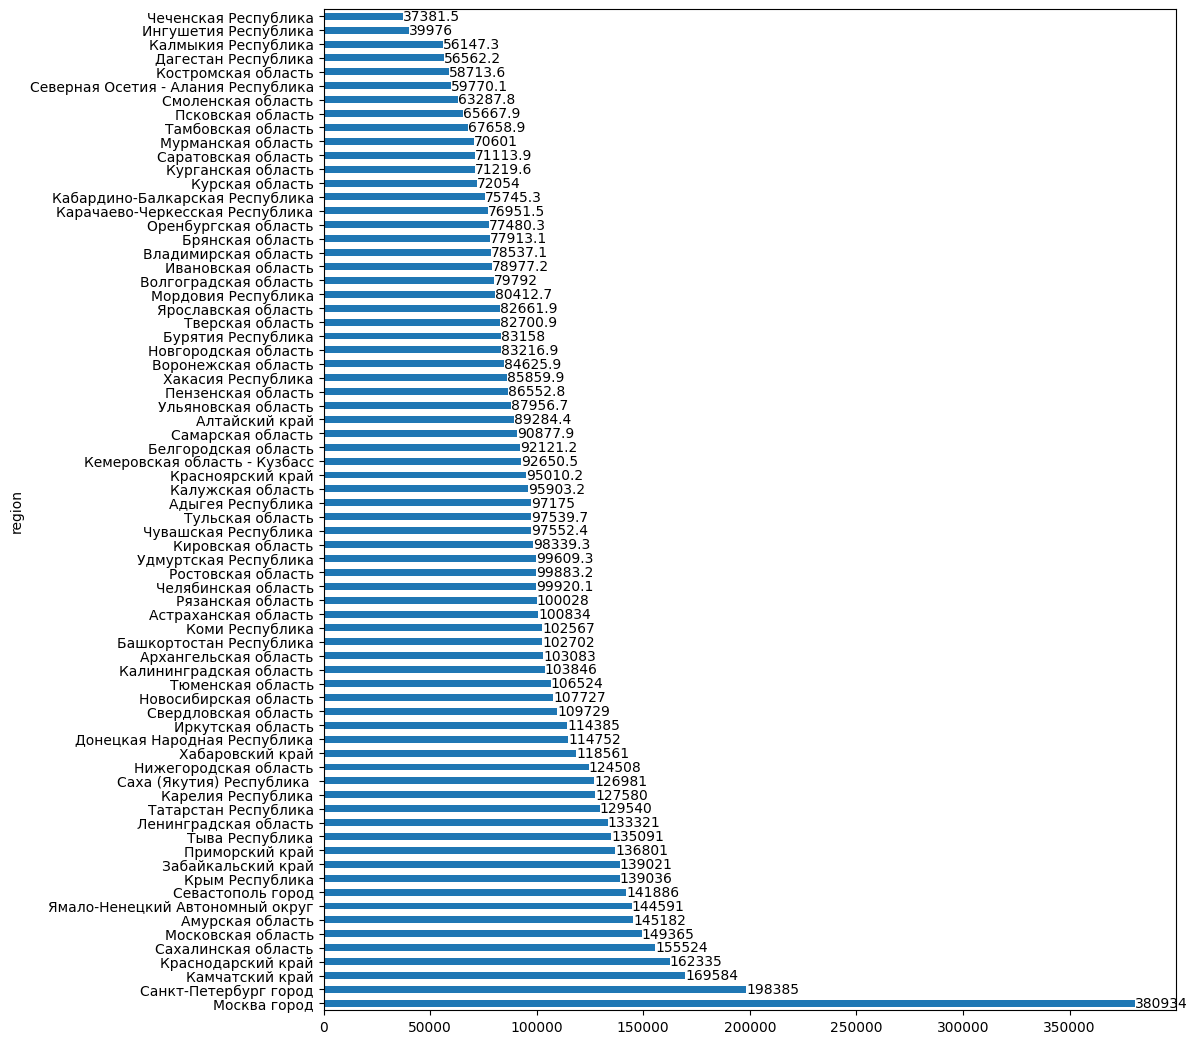

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 13))

ax = mean_price_regions.plot(kind='barh')
ax.bar_label(ax.containers [ 0 ])

plt.show()

Вывод по средней стоимости квадратного метра - Москва на первом месте, республика Чечня на последнем.Стоимость жилья в Москве почти в 2 раза дороже стоимости в Санкт-Петербурге, находящемся на втором месте.


In [ ]:
# добавим год ввода жилья в датафрейм
target_df['buildingYear'] =  target_df['objReady100PercDt'].dt.year
target_df['buildingYear'].isna().sum()

<ipython-input-33-779b20cad49a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['buildingYear'] =  target_df['objReady100PercDt'].dt.year


0

In [ ]:
buildings_by_years = pd.DataFrame(target_df.groupby(['region', 'buildingYear'])['objSquareLiving'].sum())

In [ ]:
import seaborn as sns
import plotly.express as px

In [ ]:
# постороим круговую диаграмму для анализа объемов ввода жилья по годам и регионам
fig = px.sunburst(target_df, path=['buildingYear', 'region'], values='objSquareLiving', height=700, width=700)
fig.show()

In [ ]:
# построим heatmap для наглядного исследования распределения объемов вводимого жилья по годам и регионам

buildings_by_years = buildings_by_years.reset_index()
buildings_by_years = buildings_by_years.pivot('region', 'buildingYear', 'objSquareLiving')


<ipython-input-37-838b0f4c2ec6>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



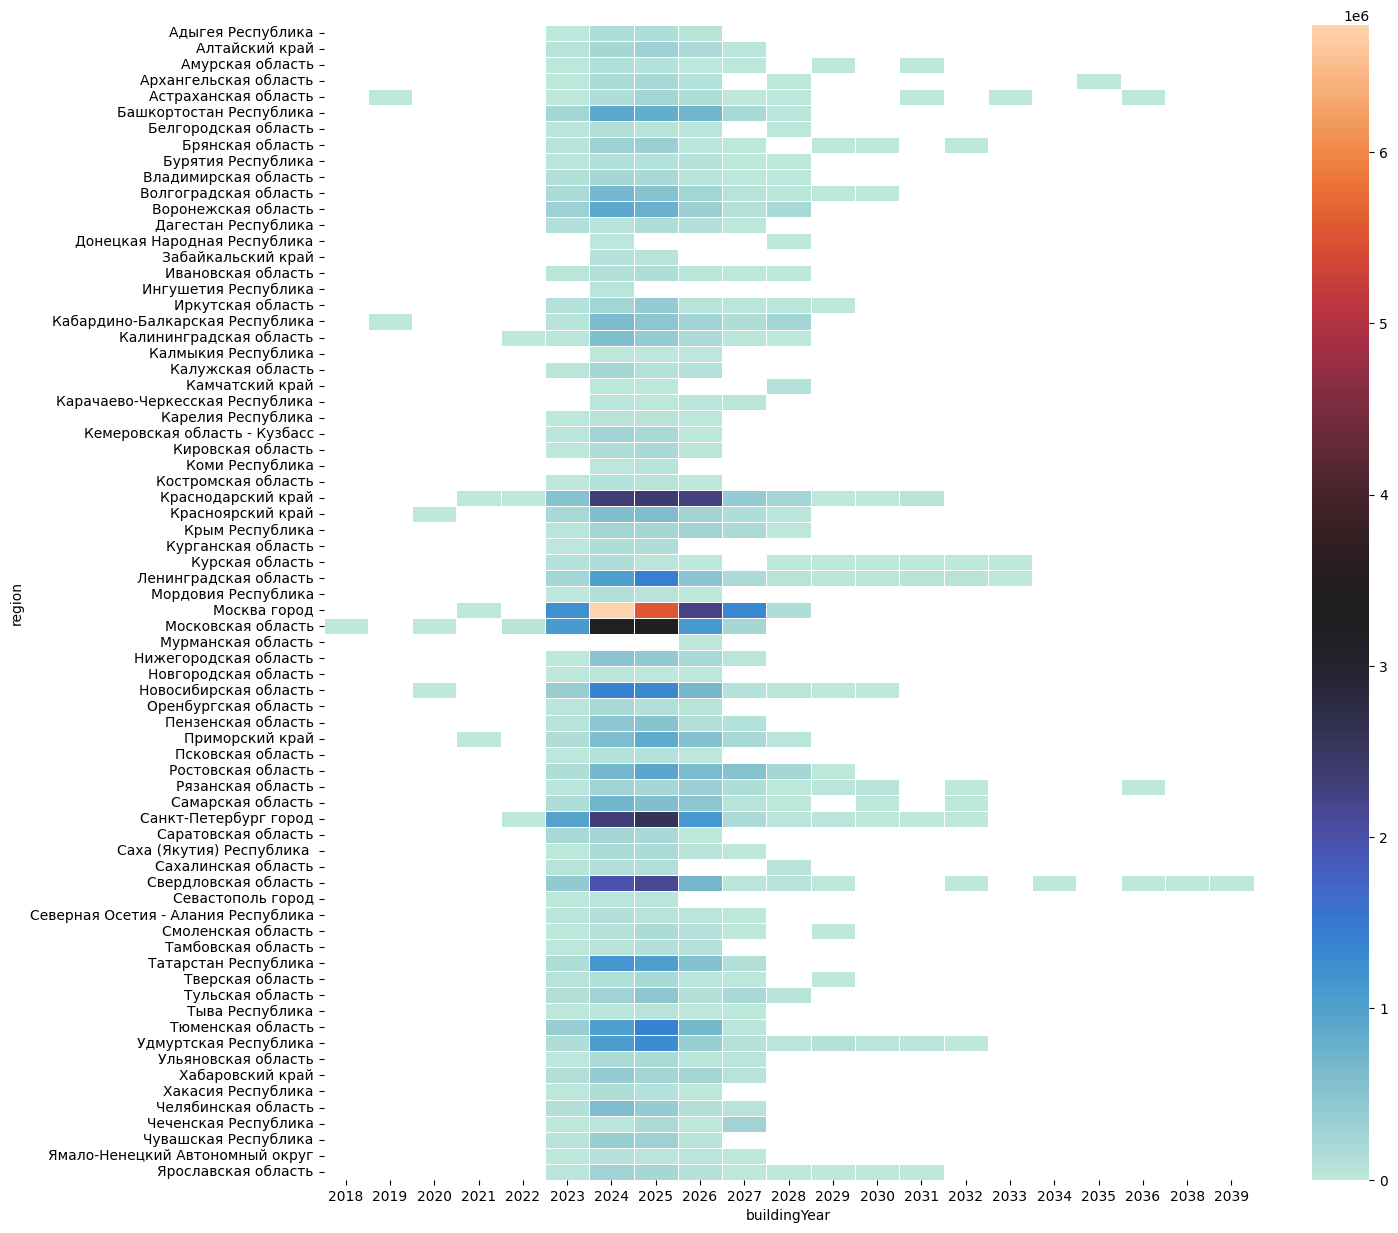

In [ ]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    buildings_by_years,
    cmap='icefire',
    fmt='.0f',
    linewidths=.5)




1.  На графике видно, что наибольшие объемы вводимого жилья приходятся на 2024, 2025, 2026 года. При этом наблюдается тенденция к понижению. Скорее всего это говорит не о реальном падении объемов, а о скорости строительства жилья, те не отражены "будущие" объемы, например за 2027й год, которые начнут строится позднее.

2.   В 2023й год не попали уже введенные объемы, тк сбор статистики мы провели в конце года.

3. Довольно много выбросов ранее 23-го года. С чем связаны выбросы из данной выборки не очень понятно. Так же есть выбросы в 2030-х годам, как например по Архангельской области.  

4. Основной процент ввода жилья расчитан на 2023-2026 года. В Лениградской и Курской областях план ввода расписан наиболее длительно, до 2033 года. При этом погодовой ввод примерно одинаковый.

5. В лидерах по вводимому объему жилья - Москва, Моск область, Санкт Петербург и Краснодарский край. Эти же регионы входят в топ 10 по средней стоимости кв метра. К лидерам приближается Свердловская область.







In [ ]:
# проведем анализ кол-ва квартир, жилплощади, этажности, кол-ва парковок, и цены
# получим средние знаечения стоимости кв м по регионам
mean_price_regions = (target_df
  .groupby('region')
  .agg(
      avg_price=('objPriceAvg', 'mean'),  avg_flatts=('objFlatCnt', 'mean'), avg_floors=('objFloorCnt', 'mean'), avg_liv_area=('objSquareLiving', 'mean'),
      avg_parking=('objElemParkingCnt', 'mean')
  )
).round(2)
mean_price_regions

,avg_price,avg_flatts,avg_floors,avg_liv_area,avg_parking
region,,,,,
Адыгея Республика,97175.00,126.85,9.08,5612.29,34.39
Алтайский край,89284.43,136.93,12.03,6658.61,23.91
Амурская область,145182.17,127.05,13.6,6215.75,4.3
Архангельская область,103082.74,134.45,9.2,5895.45,7.8
Астраханская область,100834.30,207.59,15.67,10049.90,19.81
...,...,...,...,...,...
Челябинская область,99920.13,158.97,10.81,8056.68,11.06
Чеченская Республика,37381.50,216.94,20.33,16464.53,0.0
Чувашская Республика,97552.37,129.67,12.16,7385.28,20.47


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [ ]:
def get_feature_selector(features):

  feature_selector = widgets.Dropdown(
      options=features,
      value=features[0],
      description='Выберите показатель'
  )

  return feature_selector

In [ ]:
def plot_hist_graph(selected_feature):
    # plt.figure(1, figsize=(15, 15))

    fig, ax = plt.subplots(figsize=(15, 15))

    mean_price_regions.sort_values(selected_feature, inplace=True, ascending=False)
    ax = sns.barplot(y=mean_price_regions.index, x=selected_feature, data=mean_price_regions)
    ax.bar_label(ax.containers [ 0 ])

    plt.title(selected_feature)

    plt.show()

In [ ]:
# гистограмма по данным
plot_names = mean_price_regions.columns.to_list()
feature_selector = get_feature_selector(plot_names)
interact(plot_hist_graph, selected_feature=feature_selector);

interactive(children=(Dropdown(description='Выберите показатель', options=('avg_price', 'avg_flatts', 'avg_flo…


Из графика можно сделать выводы:
1.   В лидерах по среднему количетсву квартир Москва, Рязанская область, Санкт-Петербург, Московская и Ленинградская области. В аутсайдерах - Кострома, ЯНАО, Калмыкия, Белгород.
2.   Интересны наблюдения по Рязани и Чечне. Чечня находится в лидерах по этажности и объемук жил площади, но при этом не в лидерах по количеству квартир. Можно сделать вывод, что строится высотные дома с большими площадями квартир.По Рязани наблюдается связь между высотностью, объемом жил площади и количеством квартир. То есть здесь строится больше высотных домов с большим количеством квартир, за счет чего растет средняя жил площадь объекта.
3. По Санкт Петербургу высотность домов около средних значений по стране, но при этом он находится в лидерах по кол-ву квартир на объект и жил площади. Здесь скорее жил площадь обеспечивается объемом строительства невысотных домов.   
4. По количетству парковочных мест в лидерах мегаполисы - Санкт Петербург и Москва. При том Москва с большим 2-х кратным отрывом от 2-го места и почти в 10 раз больше средних значений. По Нижнему Новгороду явно недостаточное количетсво для города миллионника, что я испытваю на личном примере :-) Но есть регионы, где парковки не строятся вообще - такие как Чечня, Мордоваия, Кострома и тд.



In [ ]:
def plot_box_graph(selected_feature):

  sns.catplot(
    x=selected_feature,
    y='region',
    data=target_df,
    kind='box',
    height=20
    );
  plt.title(selected_feature)

  plt.show()

In [ ]:
# распределение бар плот
plot_names = ['objPriceAvg', 'objFlatCnt', 'objFloorCnt', 'objSquareLiving', 'objElemParkingCnt']
feature_selector = get_feature_selector(plot_names)
interact(plot_box_graph, selected_feature=feature_selector);


interactive(children=(Dropdown(description='Выберите показатель', options=('objPriceAvg', 'objFlatCnt', 'objFl…

Из графика распределения можно сделать выводы:


1.   По цене большой разброс значений по Москве. Так же наибольший разброс по Санкт-петербургу и Краснодарскому краю - это лидеры по объемам вводимого жилья. По Москве также наблюдается большое количество выбросов в сторону более дорогой недвижимости. Так же большое количество выбросов у Краснодарского края. А по Санкт Петербургу разброс более компактный. Выбросы по Краснодару и Москве скорее всего связаны с большим количеством вводимого элитного жилья. По остальным регионом разброс плюс минус компактный, в пределах средних значений.
2.   По количеству квартир наибольший разброс значений у лидеров - Москва, Рязань, С Петербург. При этом у С Петербурга и Москвы большое количество выбросов в большую сторону. А у Рязани выбросов нет. Скорее всего это связано с общим количеством наблюдений и то, что Москва и С Петербург - мегаполисы с большим количеством многоквартирных жилых комплексов. Основное количество наблюдений лежит в границах до 500 квартир.
3. Этажность. Основное количество наблюдений находится в границах от 5 до 20 этажей. На графике наглядно видно, что средние значения по Рязанской области и Чечене смещены в большую сторону, что позвоялет им быть в лидерах по средней этажности. Однако так же видно, что лидерство обеспечено за счет меньшего количества наблюдений в целом. С учетом этого факта, в лидерах скорее всего будет Москва, где наибольший разброс значений, а средние значения в приближены к лидерам.
4. Жилая площадь. Разброс значений плюс минус схож с разбросом значений по числу квартир, тк общая жилая площаь коррелируется с количеством квартир. По Москве и С Петербургу наибольший разброс с большим количсеством выброс в большую сторону. По Рязани выбросов нет, но средние значения смещены в большую сторону.
5. Количество парковок. Хорошо видно (как строят парковки), что средние значения смещены по подавляющему числу регионов к нулю. В лидерах Москва, но самые аномальные выборсы в Краснодарском крае, где есть наблюдения на 2000, 2500 и 3500 парковок.

In [ ]:
target_df[['objFlatCnt', 'objFloorCnt', 'objSquareLiving']]

,objFlatCnt,objFloorCnt,objSquareLiving
0,68,20,6423.85
1,43,10,4812.98
2,65,12,6251.10
3,44,12,4343.90
4,225,17,12847.23
...,...,...,...
11708,103,9,6772.06
11709,110,9,7092.53
11710,103,9,6713.39
11711,103,9,6762.46


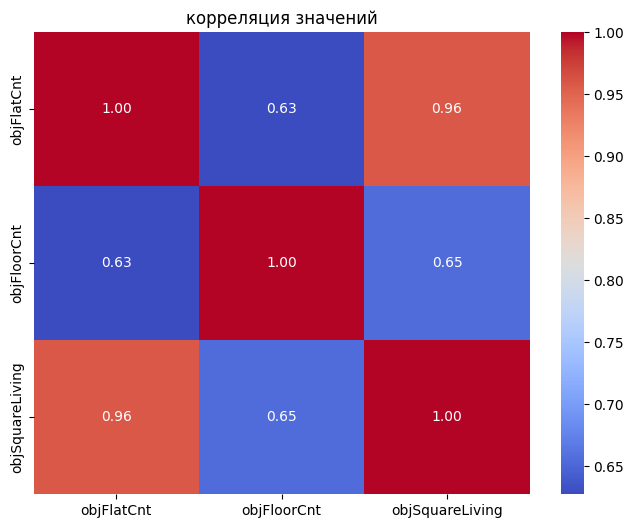

In [ ]:
# построим матрицу корреляции количества квартир, этажности и жилплощади.

corr_df = target_df[['objFlatCnt', 'objFloorCnt', 'objSquareLiving']]

correlation_matrix = corr_df.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('корреляция значений')
plt.show()

Исходя из матрицы корреляции можно подтвердить ранее сделанный вывод о положительной коррекляции жилой площади и количества квартир и умеренной положительной корелляции этажности с количеством квартир и жил площадью.